In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import statsmodels.api as sm
import scipy.optimize as scopt
import os
%matplotlib inline

c:\users\evergreen\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#load data
stocks = pd.read_csv(os.path.join('data','stocks.csv'))

stock_list = stocks['Symbols'].tolist()
print(stock_list)

num_stocks = len(stock_list)-1


data = pd.DataFrame()
for i in stock_list:
    filename=i+'.csv'
    df = pd.read_csv(os.path.join('data',filename))
    price = df[['Adj Close','Date']].set_index('Date')
    price.rename(columns={'Adj Close': i}, inplace=True)
    data = pd.concat([data,price], axis=1)
data.pop('^DJI')
print(data.head())
print(data.describe())

['AAPL', 'IBM', 'GS', 'CSCO', 'CVX', 'CAT', 'GE', 'WMT', 'XOM', 'DWDP', 'DIS', '^DJI']
                 AAPL        IBM          GS       CSCO        CVX        CAT  \
Date                                                                            
2007-01-03  10.770167  76.182991  176.424332  22.910717  48.461769  44.781055   
2007-01-04  11.009220  76.997505  174.780716  23.513851  47.990608  44.663910   
2007-01-05  10.930819  76.300468  174.956512  23.522114  48.174992  44.092781   
2007-01-08  10.984798  77.459595  179.070038  23.654301  48.789536  44.144039   
2007-01-09  11.897308  78.375984  179.377594  23.522114  48.229595  44.385666   

                   GE        WMT        XOM       DWDP        DIS  
Date                                                               
2007-01-03  25.740261  36.766621  55.702538  38.117035  28.926102  
2007-01-04  25.591133  36.944443  54.657818  37.946663  29.154470  
2007-01-05  25.462328  36.642899  55.048649  37.586975  28.917650  
2007-

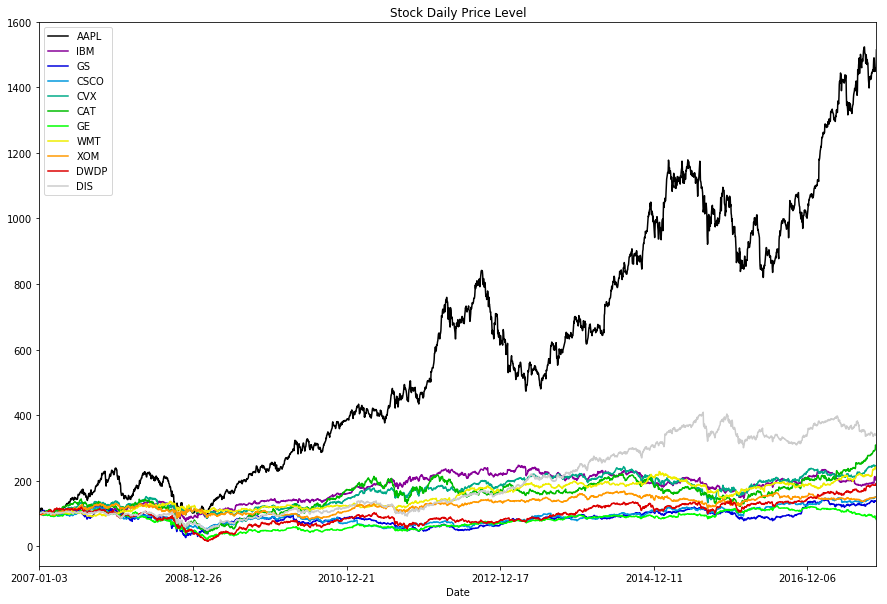

In [3]:
#normalize data to start with 100 level

ndata = (data / data.iloc[0] * 100)
ndata.plot(title="Stock Daily Price Level",cmap='nipy_spectral',figsize=(15, 10))


In [4]:
#we are going to use minimize function to optimize portfolio
def portfolio(weights):
    ''' Parameters 
    weights : array, weights for different stocks
    
    Returns
    p_return : float,  portfolio return
    p_volatility : float,  portfolio volatility
    p_return_to_risk : float, Sharpe ratio for rf=0
    '''
    weights = np.array(weights)
    p_return = np.sum(s_returns.mean() * weights) * 252
    p_volatility = np.sqrt(np.dot(weights.T, np.dot(s_returns.cov() * 252, weights)))
    p_return_to_risk = p_return/p_volatility
    return np.array([p_return, p_volatility, p_return_to_risk])

#Minimize loss
def objective(weights):
    return -portfolio(weights)[2]

#constrain,total normalized weights equal to 1
def constrain1(x):
    return ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

#weights are bound to be within 0 and 1.
bnds = tuple((0, 1) for x in range(num_stocks))



In [5]:
#we start with equal weights
weights = np.array(num_stocks * [1. / num_stocks,])
#returen
s_returns = np.log(data / data.shift(1))
# expected portfolio variance
p_volatility=np.dot(weights.T, np.dot(s_returns.cov() * 252, weights))
p_volatility


0.047485763751719874

In [6]:
%%time
p_returns = []
p_volatilities = []
for p in range (2500):
    weights = np.random.random(num_stocks)
    weights /= np.sum(weights)
    p_returns.append(np.sum(s_returns.mean() * weights) * 252)
    p_volatilities.append(np.sqrt(np.dot(weights.T,np.dot(s_returns.cov() * 252, weights))))
p_returns = np.array(p_returns)
p_volatilities = np.array(p_volatilities)

Wall time: 4.81 s


In [7]:
%%time
solution = scopt.minimize(objective, num_stocks * [1. / num_stocks,], method='SLSQP',bounds=bnds, constraints=cons)

Wall time: 188 ms


In [8]:
#minimize loss
solution

     fun: -0.8076726406337998
     jac: array([ -2.20611691e-05,   1.12788245e-01,   5.11090085e-01,
         3.71122032e-01,   1.12623565e-01,   1.13396354e-01,
         5.91067746e-01,   4.39211726e-05,   2.28451908e-01,
         3.15042637e-01,   5.93066216e-05])
 message: 'Optimization terminated successfully.'
    nfev: 91
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([  6.70794384e-01,   0.00000000e+00,   0.00000000e+00,
         1.55366171e-16,   0.00000000e+00,   8.56519716e-17,
         0.00000000e+00,   3.06930807e-01,   2.49366500e-18,
         0.00000000e+00,   2.22748087e-02])

In [9]:
#get stocks
solution['x'].round(3)


array([ 0.671,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.307,
        0.   ,  0.   ,  0.022])

In [10]:
#get resturn, valitility, and sharpe ratio
portfolio(solution['x']).round(3)

array([ 0.196,  0.243,  0.808])

In [11]:
#minimize variance
def objective2(weights):
    return portfolio(weights)[1] ** 2

solution2 = scopt.minimize(objective2, num_stocks * [1. / num_stocks,], method='SLSQP', bounds=bnds,constraints=cons)

solution2['x'].round(3)

array([ 0.051,  0.288,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.535,
        0.125,  0.   ,  0.   ])

In [12]:
#max portfolio return
cons = ({'type': 'eq', 'fun': lambda x: portfolio(x)[0] - tret},{'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)

#minimize valitility
def objective3(weights):
    return portfolio(weights)[1]

In [13]:
%%time
tgt_returns = np.linspace(0, 0.2, 50)
tgt_volatilities = []
for tgt_return in tgt_returns:
    cons = ({'type': 'eq', 'fun': lambda x: portfolio(x)[0] - tgt_return},{'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    res = scopt.minimize(objective3, num_stocks * [1. / num_stocks,], method='SLSQP',bounds=bnds, constraints=cons)
    tgt_volatilities.append(res['fun'])
tgt_volatilities = np.array(tgt_volatilities)


Wall time: 20 s


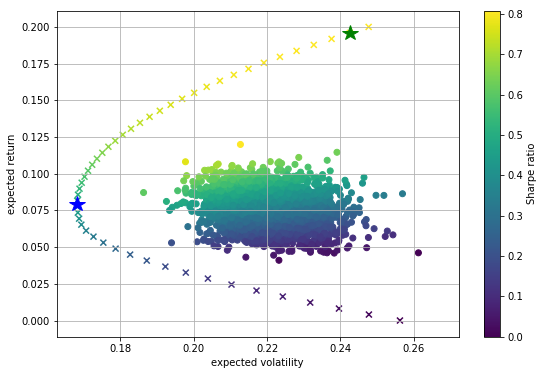

In [14]:
''' the dots----random portfolios; blue star (leftmost)--- minimum risk portfolio;  green star -- max return with min risk'''
plt.figure(figsize=(9, 6))

plt.scatter(p_volatilities, p_returns,c=p_returns/p_volatilities, marker='o')# random portfolio composition
plt.scatter(tgt_volatilities, tgt_returns,c=tgt_returns / tgt_volatilities, marker='x')# efficient frontier
plt.plot(portfolio(solution['x'])[1], portfolio(solution['x'])[0],'g*', markersize=16.0)# portfolio with highest Sharpe ratio
plt.plot(portfolio(solution2['x'])[1], portfolio(solution2['x'])[0],'b*', markersize=16.0)# minimum variance portfolio
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')